# Sightseeing in New York City
** Extracting patterns from geolocated venues and events **

Machine learning, and in particular clustering algorithms, can be used to determine which geographical areas are commonly visited and “checked into” by a given user and which areas are not. Such geographical analyses enable a wide range of services, from location-based recommenders to advanced security systems, and in general provide a more personalized user experience. 

I will use these techniques to provide two flavours of predicting analytics: 

First, I will build a simple recommender system which will provide the most trending venues in a given area. In particular, k-means tclustering can be applied to the dataset of geolocated events to partition the map into regions. For each region, we can rank the venues which are most visited. With this information, we can recommend venues and landmarks such as Times Square or the Empire State Building depending of the location of the user.

Second, I’ll determine geographical areas that are specific and personal to each user. In particular, I will use a density-based clustering technique such as DBSCAN to extract the areas where a user usually go. This analysis can be used to determine if a given data point is an _outlier_ with respect to the areas where a user normally checks in. And therefore it can be used to score a "novelty" or "anomaly" factor given the location of a given event

We will analyze this events from a public dataset shared by Gowalla on venues checkins registered between 2008 and 2010. This notebook will cover some typical data science steps:

  - data acquisition
  - data preparation
  - data exploration
  
Thereafter, we will dive into some unsupervised learning techniques: *k-means* and *dbscan* clustering, respectively for recommending popular venues and for determining outliers.

## Imports

In [25]:
%matplotlib inline

# utils
import os
import re
import urllib

# images on the notebook
from PIL import Image

# time
import pytz as tz
from datetime import datetime

# cassandra driver
from cassandra.cluster import Cluster
from cassandra.cluster import SimpleStatement, ConsistencyLevel

# data exploration
import numpy as np
np.random.seed(1337)

import pandas as pd

In [26]:
# init
datadir = './data'

# connect to cassandra
CASSANDRA_NODES = [ os.getenv('CASSANDRA_NODE', '127.0.0.1') ]

cluster = Cluster(CASSANDRA_NODES)
session = cluster.connect()

In [27]:
#matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.major.pad']='5'
plt.rcParams['ytick.major.pad']='5'

plt.style.use('ggplot')

In [28]:
# from files
filename = os.path.join(datadir, 'gowalla_events.nyc.csv')

dfe = pd.read_csv(filename, sep='\t')
dfe.columns = ['uid','timestamp','lat','lon','vid']
print(dfe.shape)
dfe.head(3)

(112390, 5)


,uid,timestamp,lat,lon,vid
0,0,2010-10-11 20:21:28-04:00,40.643885,-73.782806,23261
1,0,2010-10-07 11:27:40-04:00,40.643885,-73.782806,23261
2,5,2010-08-15 23:47:20-04:00,40.643885,-73.782806,23261


In [29]:
# Check for duplicated entries
# d = dfe[['uid', 'timestamp']].groupby(['uid', 'timestamp']).size()
# d[d>1]

In [30]:
# from database
cql_stmt = """
    SELECT * from lbsn.events;
"""
rows = session.execute(cql_stmt)
dfe = pd.DataFrame(list(rows))
print(dfe.shape)
dfe.head(3)

(112383, 5)


,uid,ts,lat,lon,vid
0,118712,2010-06-28 13:42:51,40.760333,-73.965363,286922
1,118712,2010-06-28 01:47:59,40.760857,-73.961056,740461
2,118712,2010-06-27 22:37:34,40.757067,-73.986526,11847


### Parse time and localize it 

In [31]:
def parse_datetime(ts):
    tzone = tz.timezone("America/New_York")
    return tz.utc.localize(ts).astimezone(tzone)

dfe['lt'] = dfe['ts'].apply(lambda x: parse_datetime(x))

#local date and time
dfe['date']  = dfe['lt'].astype(object).apply(lambda x : x.date())
dfe['time']  = dfe['lt'].astype(object).apply(lambda x : x.time())

#day of the week (localtime)
#hour of the day (localtime)
dfe['wd']  = dfe['date'].astype(object).apply(lambda x : x.weekday())
dfe['d']   = dfe['date'].astype(object).apply(lambda x : x.day)
dfe['h']   = dfe['time'].astype(object).apply(lambda x : x.hour)

dfe.head(3)

,uid,ts,lat,lon,vid,lt,date,time,wd,d,h
0,118712,2010-06-28 13:42:51,40.760333,-73.965363,286922,2010-06-28 09:42:51-04:00,2010-06-28,09:42:51,0,28,9
1,118712,2010-06-28 01:47:59,40.760857,-73.961056,740461,2010-06-27 21:47:59-04:00,2010-06-27,21:47:59,6,27,21
2,118712,2010-06-27 22:37:34,40.757067,-73.986526,11847,2010-06-27 18:37:34-04:00,2010-06-27,18:37:34,6,27,18


### Loading the venues data
This dataset contains just 4 columns. Let's start first by importing the data in a pandas dataframe.

In [32]:
# from database
cql_stmt = """
    SELECT * from lbsn.venues;
"""
rows = session.execute(cql_stmt)
dfv = pd.DataFrame(list(rows))
print(dfe.shape)
dfv.head(3)

(112383, 11)


,vid,lat,lon,name
0,12775,40.756659,-73.925328,Sunswick
1,1198814,40.735735,-74.065016,Dosa House
2,635262,40.752903,-73.972764,Kushi Q


### Merge events and venues data
Let's consider only events for which the venue has a known name

In [33]:
df = pd.DataFrame.merge(dfe,dfv[['vid', 'name']], on='vid', how="inner")
print(df.shape)
df.head(3)

(112383, 12)


,uid,ts,lat,lon,vid,lt,date,time,wd,d,h,name
0,118712,2010-06-28 13:42:51,40.760333,-73.965363,286922,2010-06-28 09:42:51-04:00,2010-06-28,09:42:51,0,28,9,Felidias
1,33197,2010-05-05 22:52:38,40.760333,-73.965363,286922,2010-05-05 18:52:38-04:00,2010-05-05,18:52:38,2,5,18,Felidias
2,1274,2010-01-25 23:10:16,40.760333,-73.965363,286922,2010-01-25 18:10:16-05:00,2010-01-25,18:10:16,0,25,18,Felidias


## Data exploration

First off to kick this initial analysis, lat us plot the events registered ordered temporally by increasing timestamps and grouped by date. This gives an idea of the popularity of the gowalla application during the period Jun 2009 till Oct 2010.

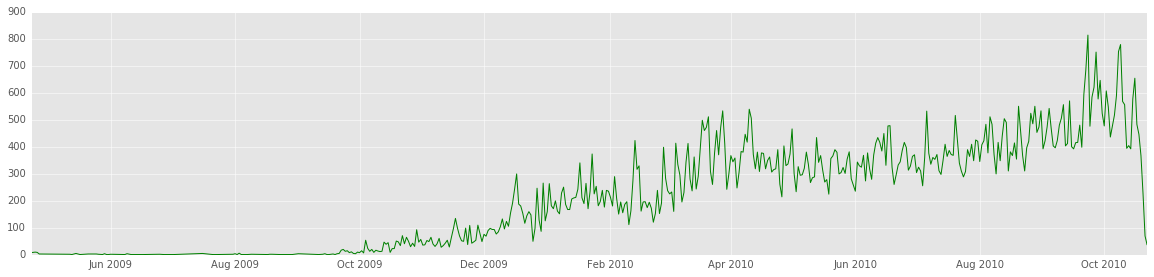

In [34]:
plt.style.use('ggplot')
plt.subplot(4, 1, 1)
top = dfe.groupby('date').size()
plt.plot(top.index, top, 'g-')

plt.show()

Let's start with answering some simple questions about the data:

  - what is the distribution of events per hour of the day, per day of the week?
  - what is the histograms of number of events registered per user?
  - which are the most popular venue of all time?

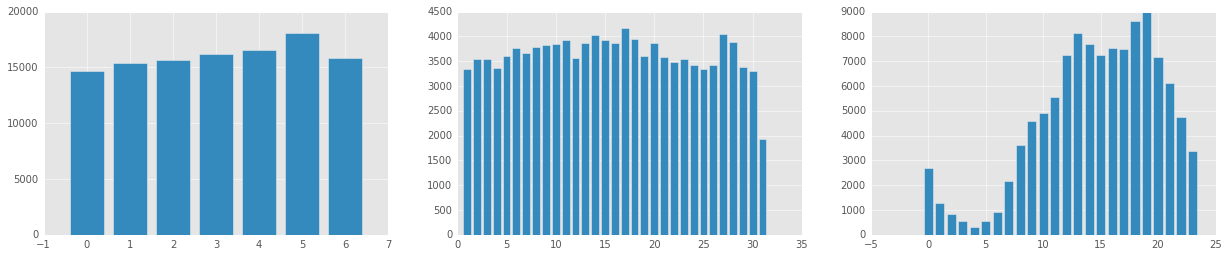

In [35]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)

plt.subplot(1, 3, 1)
top = dfe.groupby('wd').size()
plt.bar(top.index, top,align='center')

plt.subplot(1, 3, 2)
top = dfe.groupby('d').size()
plt.bar(top.index, top,align='center')

plt.subplot(1, 3, 3)
top = dfe.groupby('h').size()
plt.bar(top.index, top,align='center')

plt.show()

Interesting facts: The week seems to build up towards saturday as most popular day to record and share memorable events and venues. The end of the month has a splurge of activities (most likely to be connected with happy people getting their salaries). Finally, as expected, activity peaks during lunch and dinner times.

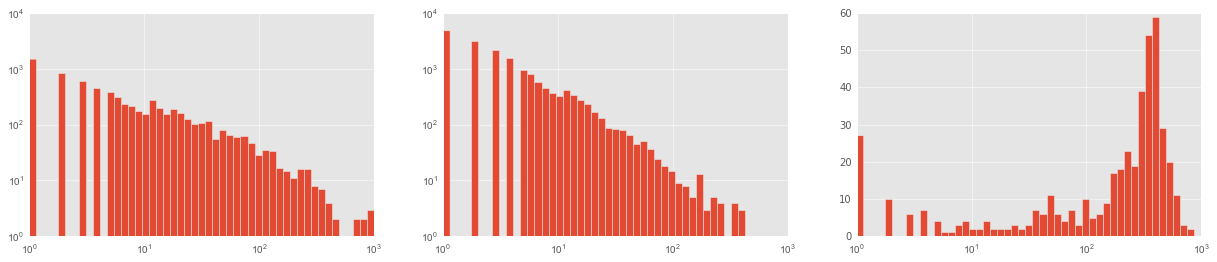

In [36]:
plt.style.use('ggplot')
fig = plt.figure()
fig.set_size_inches(21,4)

plt.subplot(1, 3, 1)
top = dfe.groupby('uid').size()
plt.hist(top, bins=np.logspace(0, 3, 50))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.subplot(1, 3, 2)
top = dfe.groupby('vid').size()
plt.hist(top, bins=np.logspace(0, 3, 50))
plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.subplot(1, 3, 3)
top = dfe.groupby('date').size()
plt.hist(top, bins=np.logspace(0, 3, 50))
plt.gca().set_xscale("log")

plt.show()

Both venues and users exhibit a typical [zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) behavior. Most of the registered events is related to a small numbers of users and venues The number of the events registered is inversely to the rank order. This applies both to users as well as venues. The third histogram shows that 60 is the most common number of events registered in a day in the city of New York, given the data available.

In [37]:
top = dfe.groupby(['vid']).size()
dfv.join(top.rename('count'), on='vid', how='inner').sort_values(by='count', ascending=False).head(10)


,vid,lat,lon,name,count
1045,12505,40.774578,-73.872006,LGA LaGuardia Airport,1679
7162,23261,40.643885,-73.782806,JFK John F. Kennedy International,1653
15215,24963,40.691247,-74.179516,EWR Newark Liberty International,1089
1432,11844,40.756880,-73.986225,Times Square,1089
4243,13022,40.752792,-73.977256,Grand Central Terminal,1005
14348,11875,40.750614,-73.993435,Madison Square Garden,430
14846,12525,40.761255,-73.977580,The Museum of Modern Art (MoMA),392
4489,12313,40.748444,-73.985732,Empire State Building,390
9407,11720,40.829406,-73.927431,Yankee Stadium,376
15801,11834,40.753816,-73.983618,Bryant Park,364


This initial analysis is a global cumulative analysis which does not take into account the fact that each area of the city as a specific  dynamic.
we could of course divide the city using an uniform grid, but this will not render justice to areas in manhattan which are highly popular.

In [39]:
top = dfe.groupby(['uid']).size()
top.sort_values(ascending=False).head(10)


uid
578     1641
22      1290
842     1145
4985    1063
4902     967
4929     925
2798     919
3480     785
2964     779
1201     740
dtype: int64

## Exploring events on the map

In [40]:
def get_map(x,y,z,size, filename) :
    static_map = "http://staticmap.openstreetmap.de/staticmap.php?center={0},{1}&zoom={2}&size={3}x{3}&maptype=mapnik".format(y,x,z,size)

    static_map_filename, headers = urllib.request.urlretrieve(static_map, filename)
    return static_map_filename

def geomap(data, zoom=13, point_size=3, point_color='r', point_alpha=1):
    #corrections to match geo with static map
    z=zoom
    picsize=1000
    wx = 1.0*360*(picsize/256)/(2**z) 
    wy = 0.76*360*(picsize/256)/(2**z) 

    #center of manhattan
    y = 40.7502
    x = -73.9752

    x_min, x_max = x-wx/2, x+wx/2
    y_min, y_max = y-wy/2, y+wy/2

    static_map_filename = os.path.join(datadir, 'nyc_staticmap_{}_{}.png'.format(z,picsize))

    if os.path.isfile(static_map_filename)==False:
        get_map(x,y,z,picsize,static_map_filename)

    img = Image.open(static_map_filename)

    #add the static map
    plt.imshow(img,zorder=0, extent=[x_min, x_max, y_min, y_max], interpolation='none', aspect='auto')

    #add the scatter plot of events
    plt.plot( 
        data['lon'], 
        data['lat'], 
        '.', 
        markerfacecolor=point_color, 
        markeredgecolor='k', 
        markersize=point_size, 
        alpha=point_alpha)

    #limit the plot to the given box
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)



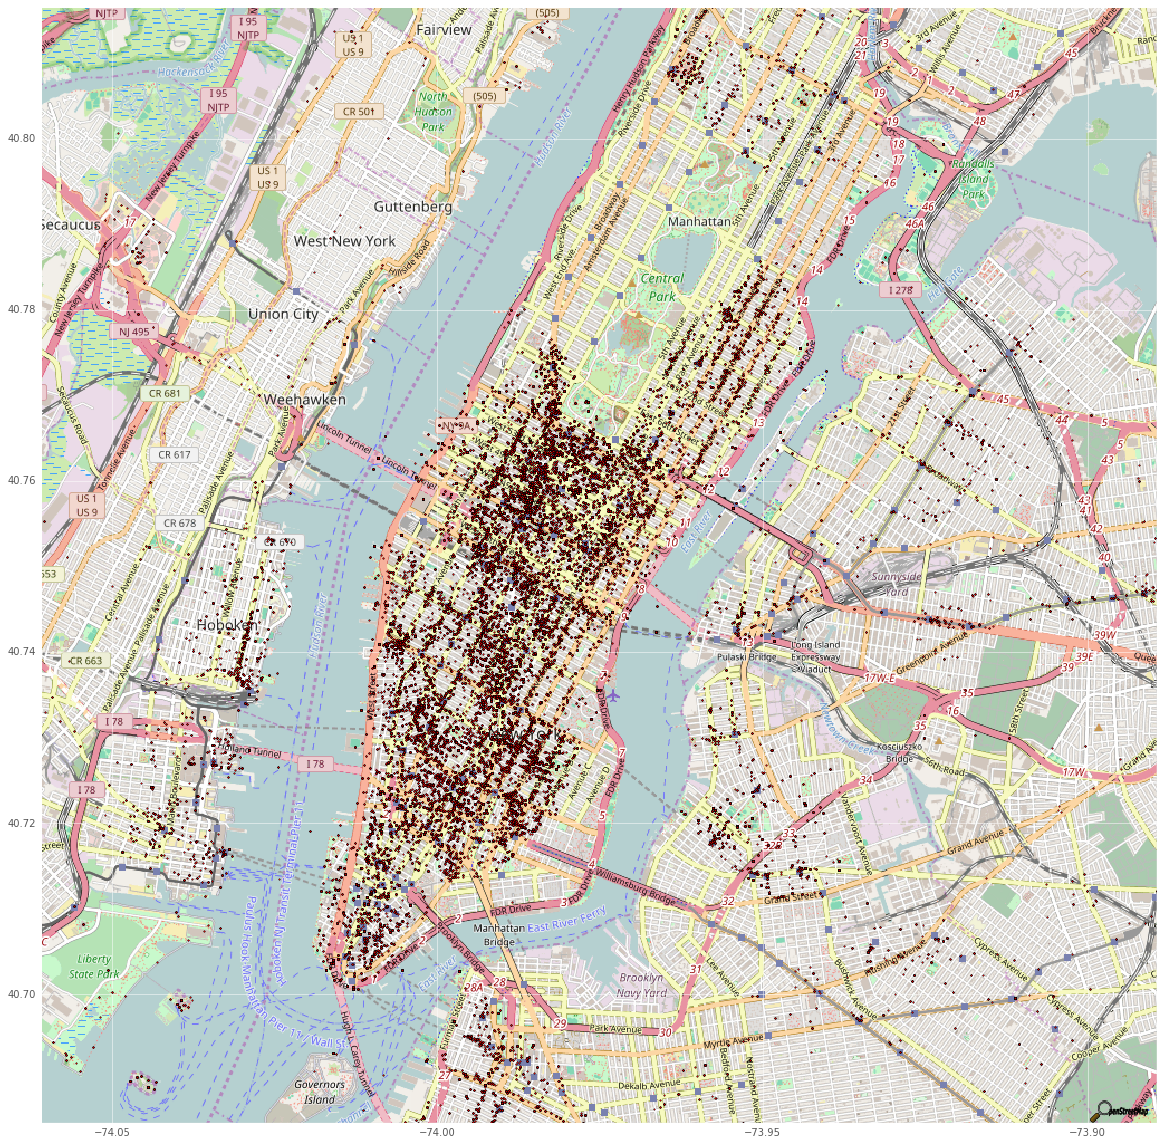

In [41]:
#prep the figure
fig = plt.figure()
fig.set_size_inches(20,20)

#map the events!
geomap(df[['lon','lat']])

#render it.
plt.show()